In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("arashnic/book-recommendation-dataset")

# print("Path to dataset files:", path)

In [2]:
# !pip install numpy==1.26.4
    


In [3]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from joblib import dump


In [4]:
# Load datasets
books = pd.read_csv("arashnic/book-recommendation-dataset/versions/3/Books.csv", low_memory=False)
ratings = pd.read_csv("arashnic/book-recommendation-dataset/versions/3/Ratings.csv")
users = pd.read_csv("arashnic/book-recommendation-dataset/versions/3/Users.csv")

In [5]:
# Merge datasets
data = pd.merge(ratings, users, on="User-ID").merge(books, on="ISBN")

In [6]:
# Filter only necessary columns
df = data[['User-ID', 'Book-Title', 'Book-Rating', 'Age', 'Location']]

In [7]:
df.head()

,User-ID,Book-Title,Book-Rating,Age,Location
0,276725,Flesh Tones: A Novel,0,NaN,"tyler, texas, usa"
1,276726,Rites of Passage,5,NaN,"seattle, washington, usa"
2,276727,The Notebook,0,16.0,"h, new south wales, australia"
3,276729,Help!: Level 1,3,16.0,"rijeka, n/a, croatia"
4,276729,The Amsterdam Connection : Level 4 (Cambridge ...,6,16.0,"rijeka, n/a, croatia"


In [8]:
df.shape

(1031136, 5)

In [9]:
# Group by 'Book-Title' and count unique 'User-ID'
book_counts = df.groupby('Book-Title')['User-ID'].nunique()

# Filter books with more than 50 unique users
popular_books = book_counts[book_counts > 50].index

# Filter the original dataframe to include only these popular books
popular_books_df = df[df['Book-Title'].isin(popular_books)]

popular_books_df.head()

,User-ID,Book-Title,Book-Rating,Age,Location
0,276725,Flesh Tones: A Novel,0,NaN,"tyler, texas, usa"
2,276727,The Notebook,0,16.0,"h, new south wales, australia"
6,276744,A Painted House,7,NaN,"torrance, california, usa"
7,276746,Lightning,0,NaN,"fort worth, ,"
8,276746,Manhattan Hunt Club,0,NaN,"fort worth, ,"


In [10]:
popular_books_df.shape


(284607, 5)

In [11]:
df = popular_books_df

In [12]:
top_10_books = book_counts.sort_values(ascending=False).head(10)
print(top_10_books)

Book-Title
Wild Animus                                        2502
The Lovely Bones: A Novel                          1295
The Da Vinci Code                                   897
The Nanny Diaries: A Novel                          821
A Painted House                                     818
Bridget Jones's Diary                               772
The Secret Life of Bees                             762
Divine Secrets of the Ya-Ya Sisterhood: A Novel     737
The Red Tent (Bestselling Backlist)                 723
Angels &amp; Demons                                 661
Name: User-ID, dtype: int64


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284607 entries, 0 to 1031129
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      284607 non-null  int64  
 1   Book-Title   284607 non-null  object 
 2   Book-Rating  284607 non-null  int64  
 3   Age          201941 non-null  float64
 4   Location     284607 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 13.0+ MB


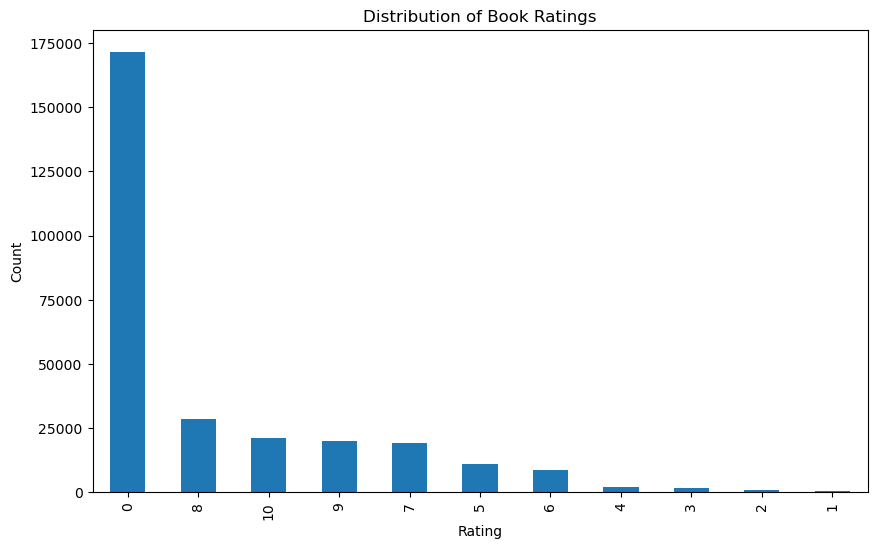

In [14]:
import matplotlib.pyplot as plt

# Count the occurrences of each rating
rating_counts = df['Book-Rating'].value_counts().sort_values(ascending=False)

# Plot the distribution
plt.figure(figsize=(10, 6))
rating_counts.plot(kind='bar')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

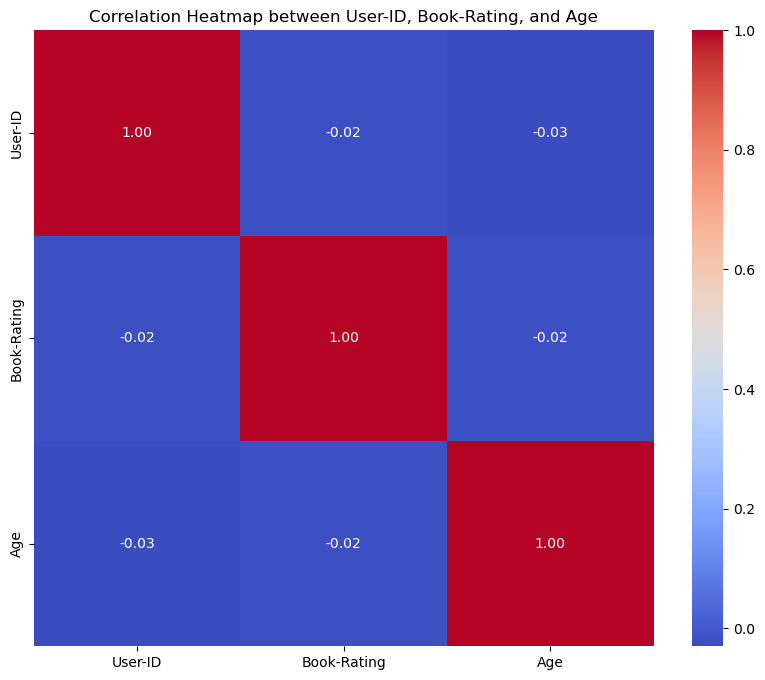

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for the specified columns
corr_matrix = df[['User-ID', 'Book-Rating', 'Age']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap between User-ID, Book-Rating, and Age')
plt.show()


In [16]:
import os

In [17]:
import os

# Get the current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: g:\BookRec


In [18]:
max_age = df['Age'].max()
print("Maximum age in the dataset:", max_age)

Maximum age in the dataset: 239.0


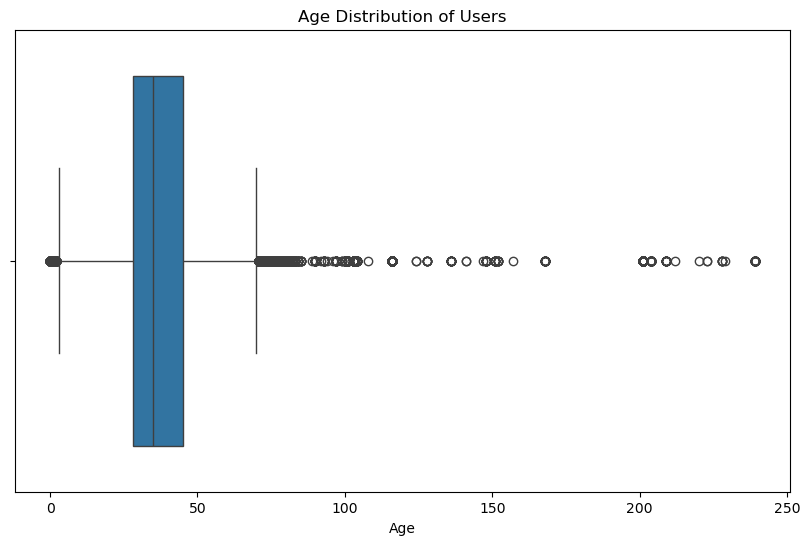

In [19]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot the age distribution using a box and whisker plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Age'])
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.show()

In [20]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Age'].quantile(0.25)
Q3 = df['Age'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to remove outliers
df = df[(df['Age'] >= lower_bound) & (df['Age'] <= upper_bound)]

df.head()

,User-ID,Book-Title,Book-Rating,Age,Location
2,276727,The Notebook,0,16.0,"h, new south wales, australia"
13,276747,Little Altars Everywhere,9,25.0,"iowa city, iowa, usa"
14,276747,How Stella Got Her Groove Back,0,25.0,"iowa city, iowa, usa"
15,276747,The Law of Love,0,25.0,"iowa city, iowa, usa"
16,276747,Waiting to Exhale,9,25.0,"iowa city, iowa, usa"


In [21]:
max_age = df['Age'].max()
print("Maximum age in the dataset:", max_age)

Maximum age in the dataset: 70.0


In [22]:
# Use the Reader to define rating scale and load dataset into Surprise
reader = Reader(rating_scale=(1, 10))
surprise_data = Dataset.load_from_df(df[['User-ID', 'Book-Title', 'Book-Rating']], reader)

In [23]:
# Train-test split
trainset, testset = train_test_split(surprise_data, test_size=0.2, random_state=42)

In [24]:
# Initialize the SVD model and train
model = SVD()
model.fit(trainset)

In [25]:
# Save the model
dump(model, 'book_recommender_model.joblib')

['book_recommender_model.joblib']